In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR,ReduceLROnPlateau  
from torch.utils.data import Dataset, DataLoader
from torch import Tensor


import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
import math as m
import csv


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

### Dataset customisée par entraîner un modèle d'auto encodeur

In [2]:
class AE_Dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data,target):

        super(AE_Dataset,self).__init__()
        
        #La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif 
        #de l'auto encodeur c'est de reconstituer la donnée initiale

        self.data = np.copy(data)
        self.targets = np.copy(target)

        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.tensor(self.data[index],dtype=torch.float32), torch.tensor(self.targets[index],dtype=torch.float32)
        

In [3]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores_(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
 
def draw_anomaly(y_true,score, seuil):
    groupDF=pd.DataFrame({
        "error":score,
        "true":y_true
    }).groupby('true')
    fig, ax=plt.subplots(figsize=(12,8))

    for name, group in groupDF:
        ax.plot(group.index,group.error,marker='x' if name==1 else 'o', linestyle='',color='r' if name==1 else 'g',label="anomalie" if name==1 else "normal")
    ax.hlines(seuil,ax.get_xlim()[0],ax.get_xlim()[1], colors ="b", zorder=100,label="Seuil")
    ax.legend()
    
    plt.title("Anomalies")
    plt.xlabel("Données")
    plt.ylabel("Score(erreur)")
    plt.show()

    
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    # precision_recall_display(ytrue, ypred)
    # roc_curve_disolay(ytrue, ypred)
    scores_(ytrue,ypred)

def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1
        
    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1
        
    elif isinstance(target,np.ndarray): 
        target[target==1]=0
        target[target==-1]=1
    return target

In [4]:
class CustomDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):
        
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler
        
        self.data = None
        self.target = None

        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()

        self.xtrain = self._xtrain # ce sont uniquement les données normales quui seront entraînées avec l'auto encoder
        self.ytrain = torch.ones((self.xtrain.shape[0],1))

        # Par contre les données de test devront à la fois contenir les données normales et les données anormales
        #Ainsi les données de test seront la concatenation entre les données normales reservées pour le test et les données contenant que des 1


        self.xtest = pd.concat([self._xtest, self.data[self.target==1]], axis=0)
        self.ytest = pd.concat([self._ytest, self.target[self.target==1]], axis=0)

        self.xtest.reset_index(drop=True, inplace=True)
        self.ytest.reset_index(drop=True, inplace=True)

        # Note : ytrain utilisé comme target lors de l'entraînement n'est le même format que ytest utilisé lors de la prédiction
        # ytrain =xtrain alors que ytest =target (labels)(0 pour donnée normale et 1 pour donnée anormale)
   
        
    def get_scaler(self):
        return self.scaler
        
    def _load_data(self):
        self.data = pd.read_csv(self.file_path)
        
        self.data.drop_duplicates(keep="last", inplace=True)
        self.target = self.data["Class"]
        self.data.drop(["Class", "Time"], axis=1,inplace=True)
        

    def _preprocess_data(self):

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        if self.scaler is not None:
            
            data_scaled_array = self.scaler.fit_transform(self.data)
            # self.data['Amount']=self.scaler.fit_transform(self.data['Amount'].values.reshape(self.data.shape[0],-1))

            #Il est impératif d'ajouter l'argument index lors de la créaction d'un dataframe à partir d'un numpy array
            # Dans notre cas, data_scaled_array est un tableau numpy. si l'argument "index" n'est pas ajouté alors l'index par défaut sera
            # RangeIndex. Le RangeIndex est incompatible avec la Index. Par exemple il sera impossible de concater deux dataframes 
            # Ou un dataframe et une serie dont l'un possède Index et l'autre RangeIndex
            self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns,index=self.data.index)
            

    def _split_data(self):
        
        self._xtrain, self._xtest, self._ytrain, self._ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

## Generator Layer

In [5]:
class Generator(nn.Module):

    def __init__(self,output_size: int,dropout: float) -> None:

        super(Generator,self).__init__()

        latent_size=m.ceil(output_size/6)
        self.latent_size=latent_size +5

        self.fc1=nn.Linear(in_features=latent_size +5,out_features=latent_size*3)
        self.residual1=nn.Linear(in_features=latent_size+5,out_features=latent_size*4)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=latent_size*3,out_features=latent_size*4)
        self.layer_norm3=nn.LayerNorm(latent_size*4)
        self.relu2=nn.ReLU()
        self.residual2=nn.Linear(in_features=latent_size*4,out_features=output_size)
        self.fc3=nn.Linear(in_features=latent_size*4,out_features=latent_size*5)
        self.layer_norm4=nn.LayerNorm(latent_size*5)
        self.relu3=nn.ReLU()
        self.dropout2=nn.Dropout(dropout)
        
        self.fc4=nn.Linear(in_features=latent_size*5,out_features=output_size)
        
        


    def forward(self,inputs: Tensor) -> Tensor:
        x=self.relu1(self.fc1(inputs))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm3(self.fc2(x) +residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm4(self.fc3(x)))
        x=self.dropout2(x)
        x=self=self.fc4(x) +residual2

        return x

## Discriminator Layer

In [6]:
class Discriminator(nn.Module):

    def __init__(self,input_size: int,dropout: float) -> None:

        super(Discriminator,self).__init__()
        latent_size=m.ceil(input_size/6)
        self.latent_size=latent_size

        self.fc1=nn.Linear(in_features=input_size,out_features=latent_size*5)
        self.residual1=nn.Linear(in_features=input_size,out_features=latent_size*4)
        self.layer_norm1=nn.LayerNorm(latent_size*5)
        self.relu1=nn.LeakyReLU(0.2)
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=latent_size*5,out_features=latent_size*4)
        self.layer_norm2=nn.LayerNorm(latent_size*4)
        self.relu2=nn.LeakyReLU(0.2)
        self.residual2=nn.Linear(in_features=latent_size*4,out_features=latent_size)
        self.fc3=nn.Linear(in_features=latent_size*4,out_features=latent_size*3)
        self.layer_norm3=nn.LayerNorm(latent_size*3)
        self.relu3=nn.LeakyReLU(0.2)
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=latent_size*3,out_features=latent_size)
        self.fc5=nn.Linear(in_features=latent_size,out_features=1)
        self.sigmoid=nn.Sigmoid()
        


    def forward(self,inputs: Tensor) -> Tensor:
        
        x=self.relu1(self.layer_norm1(self.fc1(inputs)))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm2(self.fc2(x)+residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm3(self.fc3(x)))
        x=self.dropout2(x)
        x=self.fc4(x) +residual2
        out=self.fc5(x)
        x=self.sigmoid(out)

        return out,x


## AnoGAN

In [7]:
class AnoGAN(nn.Module):

    def __init__(self,input_size: int,contamination: float=0.5,dropout: float=0.1,device: str="cuda") -> None:

        super(AnoGAN,self).__init__()
        
        self.generator=Generator(output_size=input_size, dropout=dropout)
        self.discriminator=Discriminator(input_size=input_size,dropout=dropout)
        self.latent_size=self.generator.latent_size
        self.offset=contamination
        self.test_epochs=10
        
        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")
        self.is_fitted=False

        self.generator_loss=[]
        self.discriminator_loss=[]

        

    def forward(self,inputs: Tensor) -> Tensor:
        pass

    
    def train_one_epoch(self,train_loader:DataLoader,Gen_optimizer,Discr_optimizer,loss_fn):
        
        """The function is use to train one epoch of the model
            Args: 
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader
                
        """
        last_disc_loss=0 # Computing loss per batch
        last_gen_loss=0
        running_discr_loss=0
        running_gen_loss=0
        
        for batch_index, batch in enumerate(train_loader):

            ## Entrainement du Discriminateur
            
            Discr_optimizer.zero_grad() # Putting gradient to zero in order to accumulate upcoming gradient

            #real data
            real_data,target=batch[0].to(self.device),batch[1].to(self.device)

            batch_size=real_data.shape[0]

            #Forwards pass and loss computing for real data
            _,real_outputs=self.discriminator.forward(real_data)
            real_loss=loss_fn(real_outputs.to(self.device),target) # Computing the loss
            real_loss.backward() # Computing the gradient

            # Gaussian noise generation
            z=torch.randn((batch_size,self.latent_size), device=self.device) # La méthode torch.randn permet de générer des données suivant la lois normales de moyenne 0 et d'écart type 1

            #Generation de données factices

            fake_data=self.generator.forward(z)
            labels=torch.zeros((batch_size,1),device=self.device) # Labels for fake images generated

            # Forward pass and loss computing for fake generated image
            _,fake_outputs=self.discriminator.forward(fake_data)
            fake_loss=loss_fn(fake_outputs,labels)
            fake_loss.backward()

            discriminator_loss=real_loss + fake_loss
            running_discr_loss+=discriminator_loss.item()

            Discr_optimizer.step()


            ## Entrainement du generateur
            Gen_optimizer.zero_grad()

            #Generation de données factices pour l'entrainement du generateur
            z=torch.randn((batch_size,self.latent_size),device=self.device)
            fake_data1=self.generator.forward(z)
            labels1=torch.ones((batch_size,1),device=self.device)

            _,fake_output1 = self.discriminator.forward(fake_data1)
            fake_loss1 = loss_fn(fake_output1,labels1)
            fake_loss1.backward()

            running_gen_loss+=fake_loss1.item()
            
            Gen_optimizer.step()
            
            if batch_index%100==99:
                last_disc_loss=running_discr_loss/100 # Computing loss per batch
                last_gen_loss=running_gen_loss/100
                running_discr_loss=0
                running_gen_loss=0
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        # before_lr = optimizer.param_groups[0]["lr"]
        # scheduler.step()
        # after_lr = optimizer.param_groups[0]["lr"]
        # print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_gen_loss,last_disc_loss
    
    def predict(self, dataloader,contamination,test_epochs=10):
        assert self.is_fitted==True, "Le modèle n'est pas encore entraîné donc ne peut pas faire de prédiction"
        self.test_epochs=test_epochs
        return self.decision_function(dataloader,contamination)


    def decision_function(self,dataloader: DataLoader,contamination):
        
        contaminationn= contamination if contamination != self.offset  else self.offset
        dataframe=self.compute_score_sample(dataloader)
        dataframe.loc[-dataframe["score_sample"] < (-dataframe["score_sample"]).quantile(contaminationn), "label"] = -1
        
        return dataframe['label']

    def score_sample(self,dataloader: DataLoader):
        
        dataframe=self.compute_score_sample(dataloader)

        return dataframe["score_sample"]

    def residual_loss(self,x,G_z):
        
        return torch.sum(torch.abs(x - G_z))

    def discrimination_loss(self,x,G_z):
        
      feature_G_z , _ = self.discriminator.forward(G_z)
      feature_x , _ = self.discriminator.forward(x)
        
      return torch.sum(torch.abs( feature_x - feature_G_z))
  
    def Anomaly_score(self,x,G_z,Lambda=0.1):
        
        residual_loss = self.residual_loss(x,G_z)
        discrimination_loss = self.discrimination_loss(x,G_z)
        
        total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
        return total_loss
        
    def compute_score_sample(self,dataloader: DataLoader):
        
        reconstition_errors=[]
        for batch in tqdm(dataloader):

            data,target=batch[0].to(self.device),batch[1].to(self.device)

            z=torch.randn(1, self.latent_size,device=self.device)

            z_optimizer=optim.SGD(params=[z], lr=0.001,momentum=0.9)

            error=0
            for i in range(self.test_epochs):
                
                z_optimizer.zero_grad()
                fake_data=self.generator.forward(z)
                loss=self.Anomaly_score(data,fake_data,Lambda=0.1)

                loss.backward()

                error=loss.item()
                
                z_optimizer.step()

            reconstition_errors.append(error)

        
        dataframe=pd.DataFrame({
            "score_sample" : reconstition_errors,
            "label" :[1 for _ in range(len(reconstition_errors))]
        })

        return dataframe
                

    def fit(self,train_loader,Gen_optimizer,Disc_optimizer,loss_fn,epochs=100,device="cuda"):
        """The function is used to train the model through many epochs
            Args: 
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return
                
        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
        
            print("EPOCHS : {}".format(epoch +1))
            self.train(True) # Activate training mode
            avg_loss_gen,avg_loss_disc=self.train_one_epoch(train_loader,Gen_optimizer,Disc_optimizer,loss_fn) # training the model on an epoch
            
            print(f"Generator Loss {avg_loss_gen} vs Discriminator Loss  {avg_loss_disc}")
            self.generator_loss.append(avg_loss_gen)
            self.discriminator_loss.append(avg_loss_disc)

            if avg_loss_disc < best_avg_vloss :
                best_avg_vloss=avg_loss_disc
                model_path='/home/dah/anomalie_detection/anomalie_detection/models/model_{}'.format(datetime.now().strftime('%Y%m%d_%H%')) 
                torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
        self.is_fitted=True

        return {
            "generator_loss":self.generator_loss,
            "discriminator_loss":self.discriminator_loss
        }
                

In [8]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset 
dataset = CustomDataset(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv",scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain,ytrain)
pytorch_test_dataset = AE_Dataset(xtest,ytest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=1)

#Creation de modeèle
model=AnoGAN(input_size=29,contamination=0.02,dropout=0.3,device="cpu")

#Creation des paramètres d'entrînement du modèle
lr = 0.0002
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
epochs=10
Gen_optimizer=optim.Adam(lr=lr, params=model.generator.parameters(),betas=(beta1, 0.999)) # Optimiseur
Discr_optimizer=optim.Adam(lr=lr, params=model.discriminator.parameters(),betas=(beta1, 0.999)) # Optimiseur
# scheduler = LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=50) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum
loss_fn=nn.BCELoss(reduction='mean') # La fonction de perte

history=model.fit(train_loader,Gen_optimizer=Gen_optimizer,Disc_optimizer=Discr_optimizer,loss_fn=loss_fn,epochs=epochs) #Entraînement du modèle



EPOCHS : 1
Generator Loss 0.7109646582603455 vs Discriminator Loss  1.377546330690384
EPOCHS : 2
Generator Loss 0.6915187358856201 vs Discriminator Loss  1.388855026960373
EPOCHS : 3
Generator Loss 0.6940968632698059 vs Discriminator Loss  1.387194298505783
EPOCHS : 4
Generator Loss 0.6931284552812577 vs Discriminator Loss  1.3867016172409057
EPOCHS : 5
Generator Loss 0.6942642533779144 vs Discriminator Loss  1.3857070887088776
EPOCHS : 6
Generator Loss 0.6928552132844925 vs Discriminator Loss  1.3863807010650635
EPOCHS : 7
Generator Loss 0.6931179863214493 vs Discriminator Loss  1.3865833580493927
EPOCHS : 8
Generator Loss 0.6931310176849366 vs Discriminator Loss  1.3864181077480315
EPOCHS : 9
Generator Loss 0.693178744316101 vs Discriminator Loss  1.3864636313915253
EPOCHS : 10
Generator Loss 0.6931517952680588 vs Discriminator Loss  1.3863978922367095


### Visualisation des learnings curves du Generateur et du Discriminateur.
N'ayant pas trop de données alors nous avons choisi le jeu de données de test comme je de données de validation lors de l'entraînement<br>
Rappellons que notre jeu de données d'entraînement est uniquement constitué de données normales afin d'apprendre à reconstituer correctement ces derniers.<br>
Cependata le jeu de données de test est constitué à la fois des données normales et des données anormales. Les données anormales détectées par notre auto encodeur seront celles dont l'erreur de reconstitution est la plus élevée<br>
Si notres jeux de données de test contient par exemple 1.5 % de d'anomalies alors nous choisirons d'attribuer le label -1 aux 1.5 % de données ayant une haute erreur de reconstitution

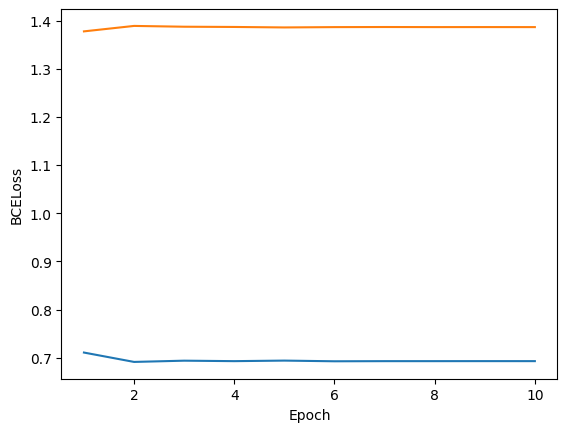

In [9]:
n=len(history['generator_loss'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['generator_loss'],label="Generator Loss")
plt.plot(epoch,history['discriminator_loss'],label="Discriminator Loss")

plt.ylabel("BCELoss")
plt.xlabel("Epoch")

plt.show()

In [10]:
# ypred=model.predict(test_loader,test_epochs=10)
# ypred=inverse_transform_target(ypred)
# evaluation(ytest,ypred)

### Histogramme de scores d'anomalies

In [11]:

score=model.score_sample(test_loader)


  0%|          | 0/43032 [00:00<?, ?it/s]

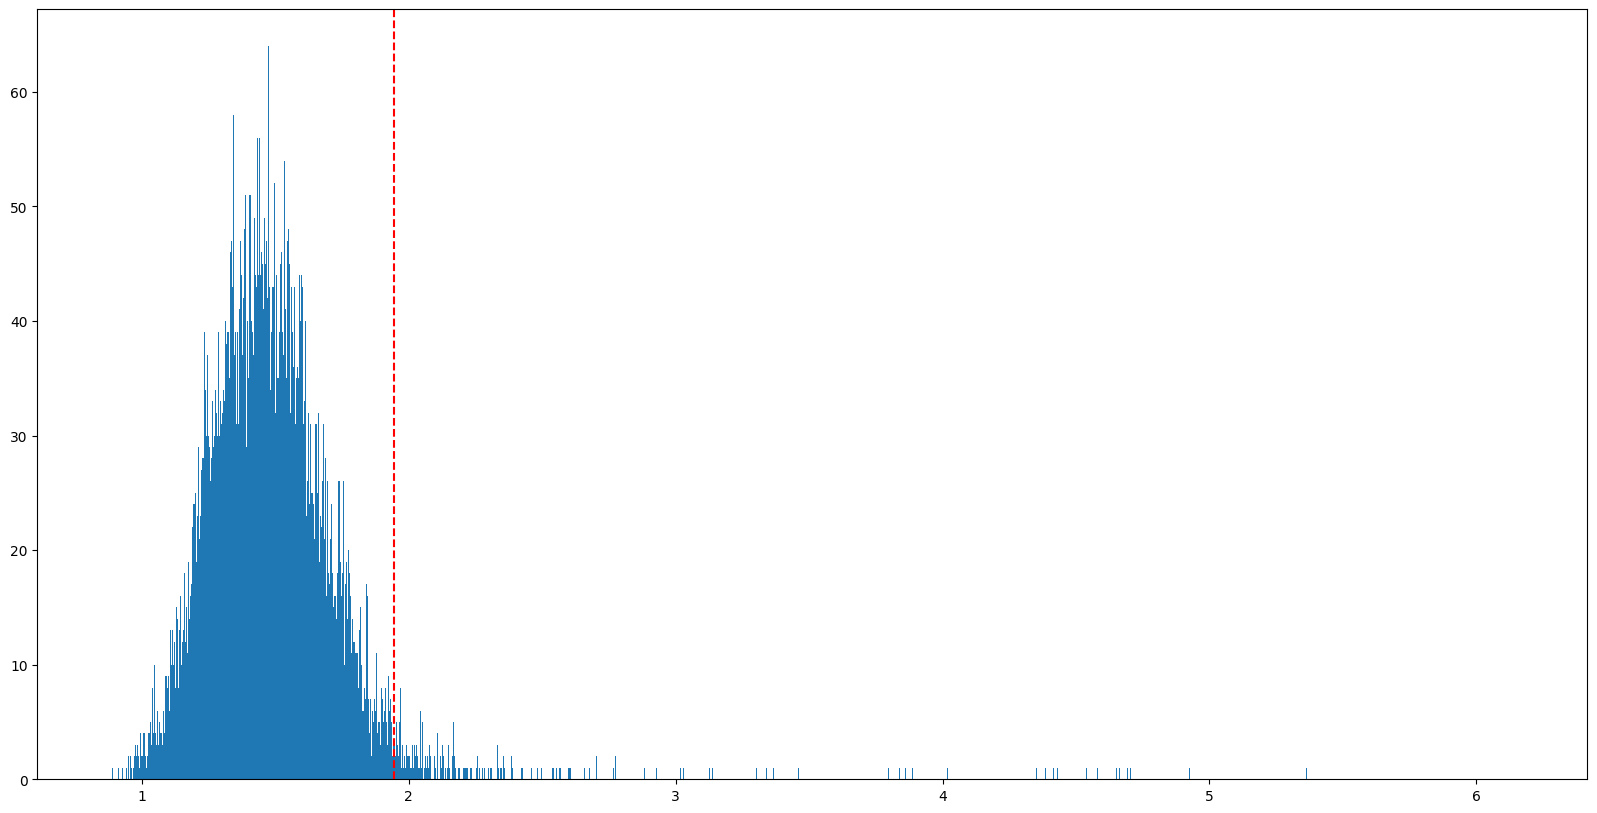

In [12]:
fig,ax=plt.subplots(figsize=(20,10))
plt.xlim(min(score)-0.2, max(score))
score.hist(bins=10000,grid=False)

# Détermination de pourcentage de contamination
q=97
plt.axvline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')

plt.show()

### Boite à moustache des scores d'anomalies

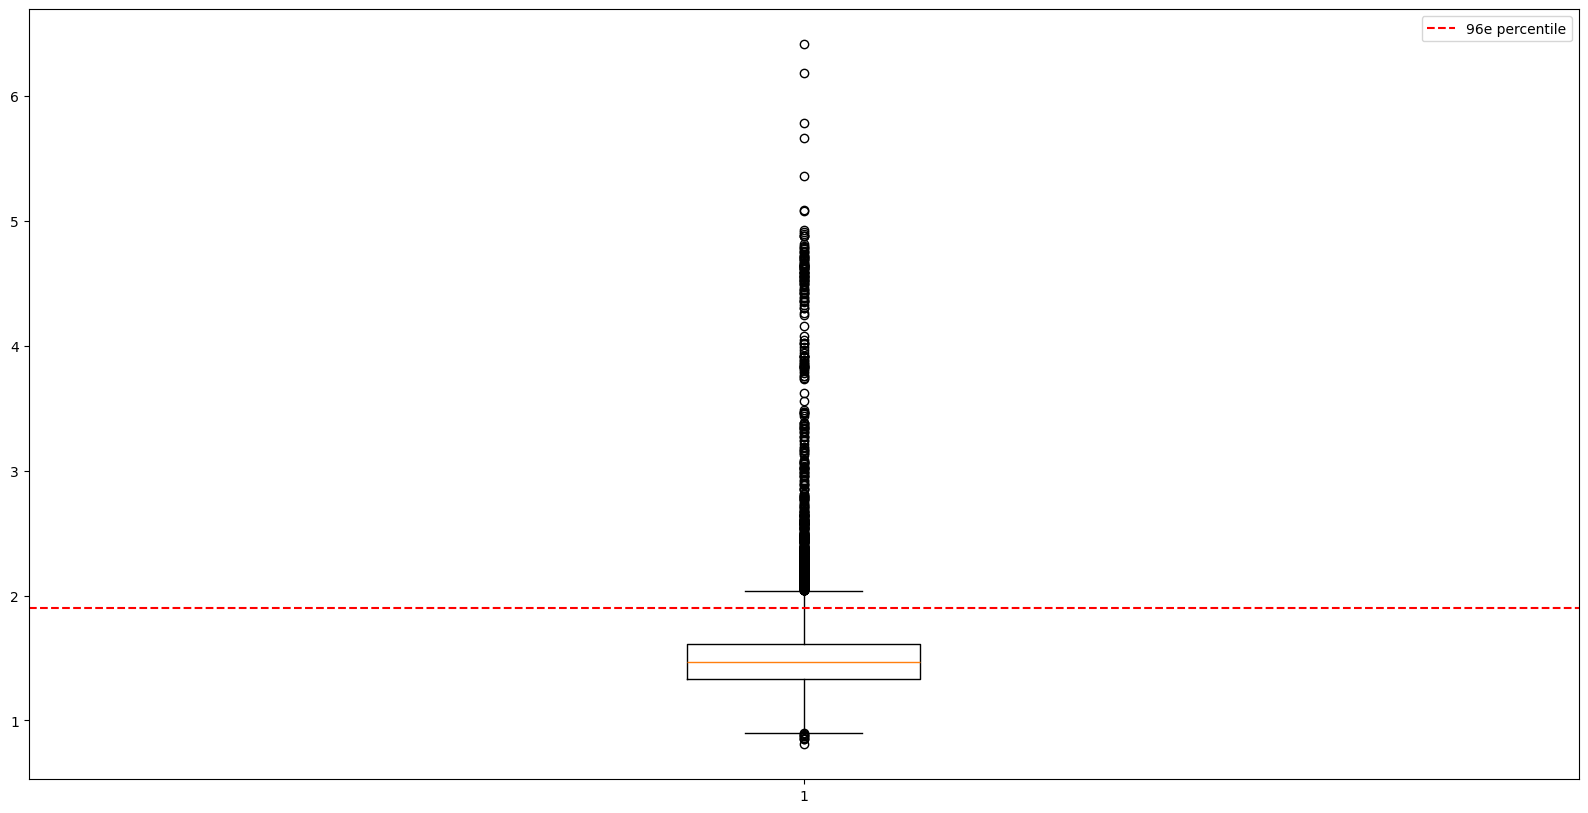

In [13]:
fig,ax=plt.subplots(figsize=(20,10))
# plt.xlim(min(score)-0.2, max(score))
plt.boxplot(score)

# Détermination de pourcentage de contamination
q=96
plt.axhline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')
plt.legend()

plt.show()


### Prediction, matrice de confusion et autres metriques

  0%|          | 0/43032 [00:00<?, ?it/s]

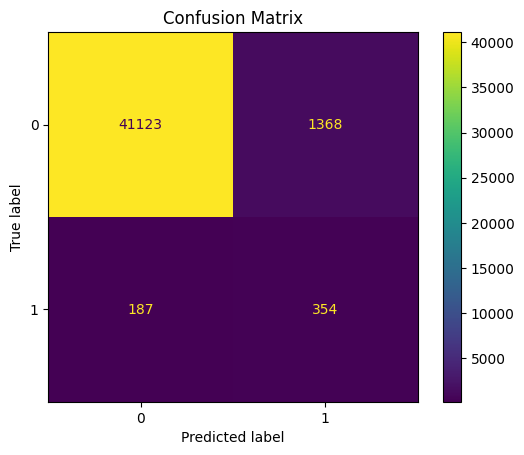

   f1_score  accuracy_score  precision_score  recall_score
0  0.312859        0.963864         0.205575      0.654344


In [14]:
ypred=model.predict(test_loader,contamination=0.04,test_epochs=10)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

### Visualisation des anomalies

In [15]:
# draw_anomaly(y_true=ytest,score=score, seuil=np.percentile(score, q=q))

  0%|          | 0/43032 [00:00<?, ?it/s]

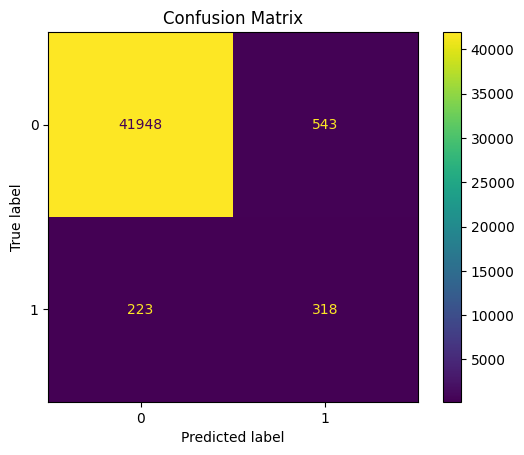

   f1_score  accuracy_score  precision_score  recall_score
0  0.453638        0.982199         0.369338        0.5878


In [16]:
ypred=model.predict(test_loader,contamination=0.02, test_epochs=110)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

### Sauvegarde des résulatats

In [17]:
file_name="../resultats/anogan.csv"

with open(file_name,"w",newline="") as csvfile:
    writer=csv.DictWriter(csvfile,fieldnames=["y_pred","score_anomalie","y_true"])
    writer.writeheader()
    n=score.shape[0]
    for i in range(n):
        row={
            "y_pred":ypred.iloc[i],
            "score_anomalie":score.iloc[i],
            "y_true":ytest.iloc[i],
        }
        writer.writerow(row)

### Courbes ROC-AUC

AnoGAN: ROC AUC=0.889


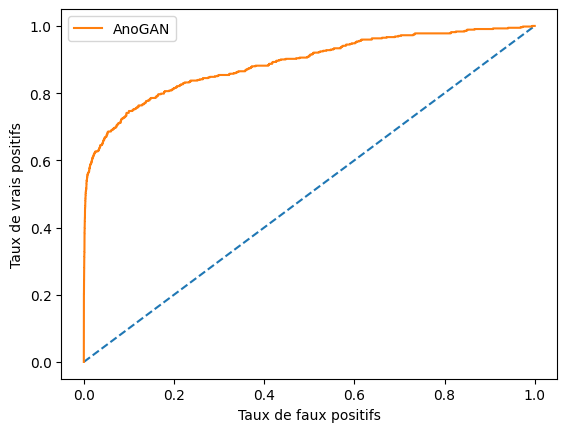

In [18]:
ns_probs = [0 for _ in range(len(ytest))]
# keep probabilities for the positive outcome only
np_score = score.tolist()
tensor=torch.tensor([np_score])
lr_probs = torch.softmax(tensor,dim=1,dtype=torch.float32).squeeze(0).numpy()

# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
lr_auc = roc_auc_score(ytest, lr_probs)
# summarize scores

print('AnoGAN: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='AnoGAN')
# axis labels
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Questions
1. Combien de couche utilisé dans notre couche d'encodeur ?
2. Quelle dimension pour la variable latente(la dimension de des donnée à la sortie des de la couche d'encodeur) ?
3. Quelle est la bonne initialisation des poids de notre réseaux (Quelle fonction utilisée) ?
4. Quel algo d'optimization utilisé (SGD, Adam, ...)?
5. Quelle fonction d'activation utilisée ?
6. Quelle pourcentage de contamination utilisé ?
7. Comment détecter des problèmes de vanishing ou exploding gradient ?

### Référence
https://arxiv.org/pdf/1703.05921.pdf <br>
https://github.com/seokinj/anoGAN/blob/master/utils.py <br>
https://github.com/seokinj/anoGAN/blob/master/train.py